<a href="https://colab.research.google.com/github/JustinDreyer/Projects/blob/main/Glucagon_like_peptide_1_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning model using the ChEMBL bioactivity data of the target protein: Glucagon-like peptide 1**

This project is adapted from a series of tutorials by **Chanin Nantasenamat** find his channel here: [*YouTube channel*](http://youtube.com/dataprofessor)




## Project aim: Create a linear regression model relating the bioactivity of compounds and their structural properties, towards the target protein (glucagon-like peptide 1)
**Project steps**
- Search for bioactivity data.
- Clean and handle missing data.
- Create "molecular fingerprtints" for each compound, describing their molecular properties.
- Exploratory data analysis, investigating the relationship between molecular properties and their activity.
- Create a simple linear regression model using RandomForestRegressor, providing structure-activity relationships.

#ChEMBL Database
###"ChEMBL is a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs."- www.ebi.ac.uk/chembl

##Install Libraries

Install ChEMBL web services package in order to retrieve bioactivity data

In [ ]:
! pip install chembl_webresource_client &> /dev/null


In [ ]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

# Search for Target protein
Target search for Glucagon-like peptide 1

In [ ]:
#Target search for coronavirus (can be used to search for target without needing to manually search online)
#target = new_client.target
#target_query = target.search('Glucagon-like peptide 1')
#targets = pd.DataFrame.from_dict(target_query)
#targets


## Select and retrieve bioactivity data for Glucagon-like peptide 1 

In [ ]:
#CHEMBL1784 is the ChEBML ID for 
selected_target='CHEMBL1784'	

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
df = pd.DataFrame.from_dict(res)

In [ ]:
df


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1447512,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '2.38', 'le': None, 'lle': None, 'sei'...",CHEMBL410972,None,CHEMBL410972,7.85,False,http://www.openphacts.org/units/Nanomolar,374445,=,1,True,=,None,IC50,nM,None,14.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,14.0
1,None,1447515,[],CHEMBL829559,Inhibitory concentration against human GLP1 re...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '2.99', 'le': None, 'lle': None, 'sei'...",CHEMBL410972,None,CHEMBL410972,9.85,False,http://www.openphacts.org/units/Nanomolar,374445,=,1,True,=,None,IC50,nM,None,0.14,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,0.14
2,None,1447518,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.47', 'le': None, 'lle': None, 'sei'...",CHEMBL265428,None,CHEMBL265428,5.27,False,http://www.openphacts.org/units/Nanomolar,374475,=,1,True,=,None,IC50,nM,None,5354.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,5354.0
3,None,1447521,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.69', 'le': None, 'lle': None, 'sei'...",CHEMBL439104,None,CHEMBL439104,6.15,False,http://www.openphacts.org/units/Nanomolar,374476,=,1,True,=,None,IC50,nM,None,713.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,713.0
4,None,1447524,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.76', 'le': None, 'lle': None, 'sei'...",CHEMBL409873,None,CHEMBL409873,6.34,False,http://www.openphacts.org/units/Nanomolar,374477,=,1,True,=,None,IC50,nM,None,454.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,None,17957100,[],CHEMBL3993844,Antagonist activity at human GLP-1R expressed ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,None,None,CHEMBL3992536,J Med Chem,2017,"{'bei': '13.65', 'le': '0.27', 'lle': '3.98', ...",CHEMBL4079193,None,CHEMBL4079193,6.16,False,http://www.openphacts.org/units/Nanomolar,2975525,=,1,True,=,None,IC50,nM,None,691.83,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,pIC50,None,UO_0000065,None,6.16
300,None,17957101,[],CHEMBL39

In [ ]:
df.to_csv('bioactivity_data_Glucagon_raw.csv', index=False)

# Handling missing data
If any compounds has missing value for the standard_value and canonical_smiles column then drop it.

In [ ]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1447512,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '2.38', 'le': None, 'lle': None, 'sei'...",CHEMBL410972,None,CHEMBL410972,7.85,False,http://www.openphacts.org/units/Nanomolar,374445,=,1,True,=,None,IC50,nM,None,14.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,14.0
1,None,1447515,[],CHEMBL829559,Inhibitory concentration against human GLP1 re...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '2.99', 'le': None, 'lle': None, 'sei'...",CHEMBL410972,None,CHEMBL410972,9.85,False,http://www.openphacts.org/units/Nanomolar,374445,=,1,True,=,None,IC50,nM,None,0.14,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,0.14
2,None,1447518,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.47', 'le': None, 'lle': None, 'sei'...",CHEMBL265428,None,CHEMBL265428,5.27,False,http://www.openphacts.org/units/Nanomolar,374475,=,1,True,=,None,IC50,nM,None,5354.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,5354.0
3,None,1447521,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.69', 'le': None, 'lle': None, 'sei'...",CHEMBL439104,None,CHEMBL439104,6.15,False,http://www.openphacts.org/units/Nanomolar,374476,=,1,True,=,None,IC50,nM,None,713.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,713.0
4,None,1447524,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.76', 'le': None, 'lle': None, 'sei'...",CHEMBL409873,None,CHEMBL409873,6.34,False,http://www.openphacts.org/units/Nanomolar,374477,=,1,True,=,None,IC50,nM,None,454.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,454.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,None,17957100,[],CHEMBL3993844,Antagonist activity at human GLP-1R expressed ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,None,None,CHEMBL3992536,J Med Chem,2017,"{'bei': '13.65', 'le': '0.27', 'lle': '3.98', ...",CHEMBL4079193,None,CHEMBL4079193,6.16,False,http://www.openphacts.org/units/Nanomolar,2975525,=,1,True,=,None,IC50,nM,None,691.83,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,pIC50,None,UO_0000065,None,6.16
300,None,17957101,[],CHEMBL39

In [ ]:
len(df2.canonical_smiles.unique())

212

## Drop duplicates

In [ ]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1447512,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '2.38', 'le': None, 'lle': None, 'sei'...",CHEMBL410972,None,CHEMBL410972,7.85,False,http://www.openphacts.org/units/Nanomolar,374445,=,1,True,=,None,IC50,nM,None,14.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,14.0
2,None,1447518,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.47', 'le': None, 'lle': None, 'sei'...",CHEMBL265428,None,CHEMBL265428,5.27,False,http://www.openphacts.org/units/Nanomolar,374475,=,1,True,=,None,IC50,nM,None,5354.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,5354.0
3,None,1447521,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.69', 'le': None, 'lle': None, 'sei'...",CHEMBL439104,None,CHEMBL439104,6.15,False,http://www.openphacts.org/units/Nanomolar,374476,=,1,True,=,None,IC50,nM,None,713.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,713.0
4,None,1447524,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.76', 'le': None, 'lle': None, 'sei'...",CHEMBL409873,None,CHEMBL409873,6.34,False,http://www.openphacts.org/units/Nanomolar,374477,=,1,True,=,None,IC50,nM,None,454.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,454.0
5,None,1447527,[],CHEMBL874550,Inhibitory concentration required against huma...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,None,None,CHEMBL1137923,Bioorg. Med. Chem. Lett.,2004,"{'bei': '1.70', 'le': None, 'lle': None, 'sei'...",CHEMBL410973,None,CHEMBL410973,6.09,False,http://www.openphacts.org/units/Nanomolar,374478,=,1,True,=,None,IC50,nM,None,804.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,nM,UO_0000065,None,804.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,None,17957021,[],CHEMBL3993843,Antagonist activity at human GLP-1R expressed ...,B,None,None,BAO_0000190,BAO_0000219,cell-based format,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,None,None,CHEMBL3992536,J Med Chem,2017,"{'bei': '13.77', 'le': '0.27', 'lle': '4.03', ...",CHEMBL4079193,None,CHEMBL4079193,6.21,False,http://www.openphacts.org/units/Nanomolar,2975525,=,1,True,=,None,IC50,nM,None,610.0,CHEMBL1784,Homo sapiens,Glucagon-like peptide 1 receptor,9606,None,None,IC50,uM,UO_0000065,None,0.61
285,None,17957022,[],CHEMBL3993

# Data pre-processing of the bioactivity data
Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,14.0
2,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,5354.0
3,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,713.0
4,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,454.0
5,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,804.0
...,...,...,...
284,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,610.0
285,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,650.0
291,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,21000.0
302,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,26.0


### Save dataframe to csv

In [ ]:
df3.to_csv('Glucagon_bioactivity_data_preprocessed.csv', index=False)

## Labeling compounds as either being active, inactive or intermediate
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [ ]:
df4 = pd.read_csv('Glucagon_bioactivity_data_preprocessed.csv')

In [ ]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,14.0,active
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,5354.0,intermediate
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,713.0,active
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,454.0,active
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,804.0,active
...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,610.0,active
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,650.0,active
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,21000.0,inactive
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,26.0,active


# Install conda and rdkit


In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh &> /dev/null
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh &> /dev/null
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local &> /dev/null
! conda install -c rdkit rdkit -y &> /dev/null
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import pandas as pd

In [ ]:
df = df5
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,14.0,active
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,5354.0,intermediate
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,713.0,active
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,454.0,active
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,804.0,active
...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,610.0,active
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,650.0,active
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,21000.0,inactive
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,26.0,active


In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL410972,14.0,active,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
1,CHEMBL265428,5354.0,intermediate,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
2,CHEMBL439104,713.0,active,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
3,CHEMBL409873,454.0,active,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
4,CHEMBL410973,804.0,active,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
...,...,...,...,...
207,CHEMBL4079193,610.0,active,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...
208,CHEMBL1341270,650.0,active,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...
209,CHEMBL1628665,21000.0,inactive,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...
210,CHEMBL4130148,26.0,active,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...


# Calculate Lipinski descriptors
Lipinski rule of 5 helps in distinguishing between drug like and non drug like molecules. It predicts high probability of success or failure due to drug likeness for molecules complying with 2 or more of the following rules

- Molecular mass less than 500 Dalton
- High lipophilicity (expressed as LogP less than 5)
- Less than 5 hydrogen bond donors
- Less than 10 hydrogen bond acceptors
- Molar refractivity should be between 40-130

http://www.scfbio-iitd.res.in/software/drugdesign/lipinski.jsp

## Import Libraries

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

## Calculate Descriptors

In [ ]:

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,3297.682,-13.99983,49.0,46.0
1,3593.961,-15.58750,49.0,51.0
2,3635.058,-14.45080,49.0,51.0
3,3594.005,-14.72400,49.0,51.0
4,3593.961,-15.58750,49.0,51.0
...,...,...,...,...
207,451.283,2.18440,1.0,8.0
208,440.731,2.73880,1.0,6.0
209,498.490,3.21620,1.0,6.0
210,4123.604,-20.22293,57.0,58.0


## Combine DataFrames

In [ ]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,3297.682,-13.99983,49.0,46.0
1,3593.961,-15.58750,49.0,51.0
2,3635.058,-14.45080,49.0,51.0
3,3594.005,-14.72400,49.0,51.0
4,3593.961,-15.58750,49.0,51.0
...,...,...,...,...
207,451.283,2.18440,1.0,8.0
208,440.731,2.73880,1.0,6.0
209,498.490,3.21620,1.0,6.0
210,4123.604,-20.22293,57.0,58.0


In [ ]:
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,14.0,active
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,5354.0,intermediate
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,713.0,active
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,454.0,active
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,804.0,active
...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,610.0,active
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,650.0,active
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,21000.0,inactive
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,26.0,active


In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,14.0,active,3297.682,-13.99983,49.0,46.0
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,5354.0,intermediate,3593.961,-15.58750,49.0,51.0
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,713.0,active,3635.058,-14.45080,49.0,51.0
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,454.0,active,3594.005,-14.72400,49.0,51.0
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,804.0,active,3593.961,-15.58750,49.0,51.0
...,...,...,...,...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,610.0,active,451.283,2.18440,1.0,8.0
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,650.0,active,440.731,2.73880,1.0,6.0
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,21000.0,inactive,498.490,3.21620,1.0,6.0
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,26.0,active,4123.604,-20.22293,57.0,58.0


# Convert IC50 to pIC50
* convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).
* This custom function pIC50() will accept a DataFrame as input and will:
convert IC50 values from the standard_value column,from nM to M
* Take the molar value and apply -log10
* Delete the standard_value column and create a new pIC50 column

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_combined.standard_value.describe()


count       212.000000
mean       4430.560165
std        8149.455686
min           0.030000
25%           3.152000
50%         756.500000
75%       10000.000000
max      100000.000000
Name: standard_value, dtype: float64

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000 #fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3297.682,-13.99983,49.0,46.0,14.0
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,intermediate,3593.961,-15.58750,49.0,51.0,5354.0
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3635.058,-14.45080,49.0,51.0,713.0
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3594.005,-14.72400,49.0,51.0,454.0
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3593.961,-15.58750,49.0,51.0,804.0
...,...,...,...,...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,active,451.283,2.18440,1.0,8.0,610.0
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,active,440.731,2.73880,1.0,6.0,650.0
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,inactive,498.490,3.21620,1.0,6.0,21000.0
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,4123.604,-20.22293,57.0,58.0,26.0


In [ ]:
df_norm.standard_value_norm.describe()

count       212.000000
mean       4430.560165
std        8149.455686
min           0.030000
25%           3.152000
50%         756.500000
75%       10000.000000
max      100000.000000
Name: standard_value_norm, dtype: float64

In [ ]:
df_norm.head()

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3297.682,-13.99983,49.0,46.0,14.0
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,intermediate,3593.961,-15.58750,49.0,51.0,5354.0
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3635.058,-14.45080,49.0,51.0,713.0
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3594.005,-14.72400,49.0,51.0,454.0
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3593.961,-15.58750,49.0,51.0,804.0


In [ ]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3297.682,-13.99983,49.0,46.0,7.853872
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,intermediate,3593.961,-15.58750,49.0,51.0,5.271322
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3635.058,-14.45080,49.0,51.0,6.146910
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3594.005,-14.72400,49.0,51.0,6.342944
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3593.961,-15.58750,49.0,51.0,6.094744
...,...,...,...,...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,active,451.283,2.18440,1.0,8.0,6.214670
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,active,440.731,2.73880,1.0,6.0,6.187087
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,inactive,498.490,3.21620,1.0,6.0,4.677781
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,4123.604,-20.22293,57.0,58.0,7.585027


In [ ]:
df_final.pIC50.describe()


count    212.000000
mean       6.748961
std        1.821308
min        4.000000
25%        5.000000
50%        6.121910
75%        8.501894
max       10.522879
Name: pIC50, dtype: float64

### Removing the 'intermediate' bioactivity class
Here, we will be removing the intermediate class from our data set.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3297.682,-13.99983,49.0,46.0,7.853872
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3635.058,-14.45080,49.0,51.0,6.146910
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3594.005,-14.72400,49.0,51.0,6.342944
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3593.961,-15.58750,49.0,51.0,6.094744
5,CHEMBL409371,CC[C@H](C)[C@H](NC(=O)[C@H](CCCCNC(=O)COCCOCCN...,inactive,3574.959,-16.70120,50.0,52.0,5.000000
...,...,...,...,...,...,...,...,...
203,CHEMBL3616774,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3956.472,-11.75606,55.0,54.0,10.000000
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,active,451.283,2.18440,1.0,8.0,6.214670
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,active,440.731,2.73880,1.0,6.0,6.187087
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,inactive,498.490,3.21620,1.0,6.0,4.677781


# Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors
### Import library

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

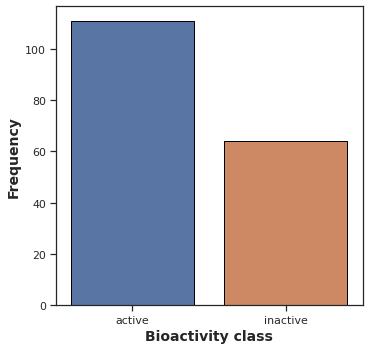

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

## Scatter plot of MW versus LogP

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.


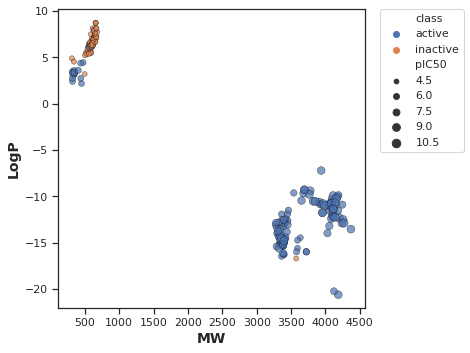

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

## Box plots

pIC50 value

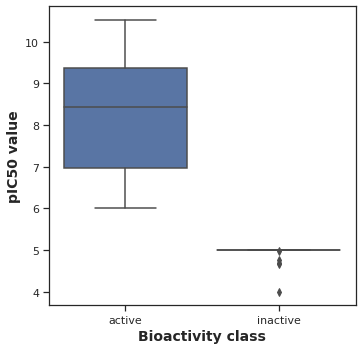

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

Statistical analysis | Mann-Whitney U Test

In [ ]:

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.632115e-29,0.05,Different distribution (reject H0)


MW

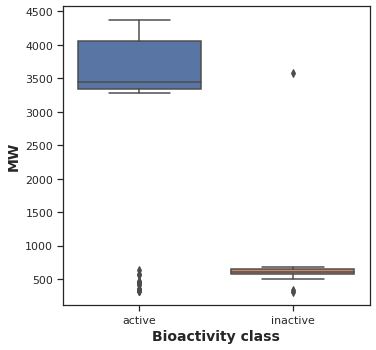

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,974.0,7.012632e-16,0.05,Different distribution (reject H0)


LogP

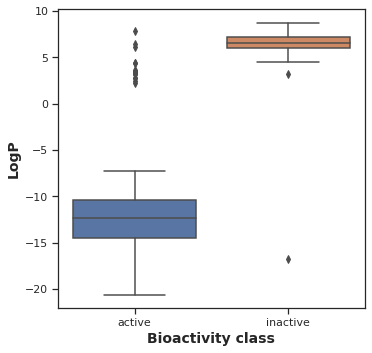

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,217.0,2.566964e-25,0.05,Different distribution (reject H0)


NumHDonors

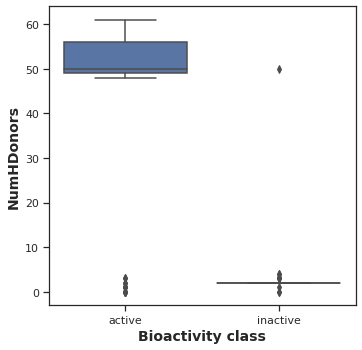

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,864.5,1.275535e-17,0.05,Different distribution (reject H0)


NumHAcceptors

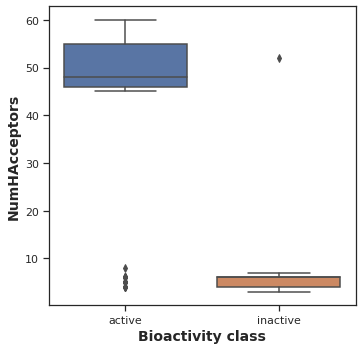

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,579.0,9.708148e-21,0.05,Different distribution (reject H0)


Interpretation of Statistical Results
Box Plots



- pIC50 values

pIC50 values between the actives and inactives displayed statistically significant difference.Results could be statisically more meaningful with a larger sampler size or tweaking of the definition of intermediate activity

- Lipinski's descriptors

The 4 Lipinski's descriptors showed statistically significant difference between the active and inactive compounds.

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: Glucagon_bioactivity_data_preprocessed.csv (deflated 95%)
  adding: mannwhitneyu_MW.csv (deflated 7%)
  adding: plot_MW_vs_LogP.pdf (deflated 12%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: bioactivity_data_Glucagon_raw.csv (deflated 95%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 39%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 7%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)


# **Calculating Molecular Descriptors**

# Download PaDEL-Descriptor

In [ ]:
! pip install padelpy


     |████████████████████████████████| 20.9 MB 1.3 MB/s 


In [ ]:
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip 
! unzip fingerprints_xml.zip 

--2021-11-18 03:15:58--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2021-11-18 03:15:58--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0s      

2021-11-18 03:15:59 (94.8 MB/s) - ‘fingerprints_xml.zip’ saved [10871/10871]

Archive:  fingerprints_xm

In [ ]:
import glob
xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [ ]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

Create a dictionary

In [ ]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'Substructure': 'SubstructureFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml'}

# Bioactivity Data

In [60]:
df3 = df_final

In [61]:
df3

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL410972,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3297.682,-13.99983,49.0,46.0,7.853872
1,CHEMBL265428,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,intermediate,3593.961,-15.58750,49.0,51.0,5.271322
2,CHEMBL439104,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3635.058,-14.45080,49.0,51.0,6.146910
3,CHEMBL409873,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3594.005,-14.72400,49.0,51.0,6.342944
4,CHEMBL410973,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,3593.961,-15.58750,49.0,51.0,6.094744
...,...,...,...,...,...,...,...,...
207,CHEMBL4079193,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,active,451.283,2.18440,1.0,8.0,6.214670
208,CHEMBL1341270,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,active,440.731,2.73880,1.0,6.0,6.187087
209,CHEMBL1628665,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,inactive,498.490,3.21620,1.0,6.0,4.677781
210,CHEMBL4130148,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,active,4123.604,-20.22293,57.0,58.0,7.585027


DATA from previous parts

In [62]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [63]:
df3_selection

,canonical_smiles,molecule_chembl_id
0,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL410972
1,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL265428
2,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL439104
3,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL409873
4,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL410973
...,...,...
207,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)N=C(...,CHEMBL4079193
208,Cn1c2c(c(=O)n(C)c1=O)C(C(F)(F)F)(C(F)(F)F)NC(c...,CHEMBL1341270
209,COc1ccc2c(c1)N(c1ccccc1F)C(=O)[C@@]2(CCC(=O)[O...,CHEMBL1628665
210,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,CHEMBL4130148


##Calculate fingerprint descriptors

In [64]:
fp['PubChem']

'PubchemFingerprinter.xml'

In [65]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

# **Preparing the X and Y Data Matrices**

# X data matrix

In [66]:
df3_X = pd.read_csv('PubChem.csv')

In [67]:
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL410972,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL265428,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL439104,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL409873,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL409371,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,CHEMBL1341270,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
208,CHEMBL1628665,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209,CHEMBL3616774,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
210,CHEMBL4128112,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
208,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
210,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Y variable
## Convert IC50 to pIC50

In [69]:
df3_Y = df3['pIC50']
df3_Y

0      7.853872
1      5.271322
2      6.146910
3      6.342944
4      6.094744
         ...   
207    6.214670
208    6.187087
209    4.677781
210    7.585027
211    5.946038
Name: pIC50, Length: 212, dtype: float64

### Combining X and Y variable

In [70]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.853872
1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.271322
2,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.146910
3,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.342944
4,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.094744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.214670
208,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.187087
209,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.677781
210,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.585027


# **Regression Models with Random Forest**

In [71]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [72]:
df = dataset3

### 3.1. Input features

In [73]:
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
208,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
210,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.2. Output features

In [74]:
Y = df.pIC50
Y

0      7.853872
1      5.271322
2      6.146910
3      6.342944
4      6.094744
         ...   
207    6.214670
208    6.187087
209    4.677781
210    7.585027
211    5.946038
Name: pIC50, Length: 212, dtype: float64

## 3.4. Remove low variance features

In [75]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [76]:
X.shape

(212, 166)

## 4. Data split (80/20 ratio)

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [78]:
X_train.shape, Y_train.shape

((169, 166), (169,))

In [79]:
X_test.shape, Y_test.shape

((43, 166), (43,))

# 5. Building a Regression Model using Random Forest

In [80]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.3549664702566999

In [81]:
Y_pred = model.predict(X_test)

## 6. Scatter Plot of Experimental vs Predicted pIC50 Values


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

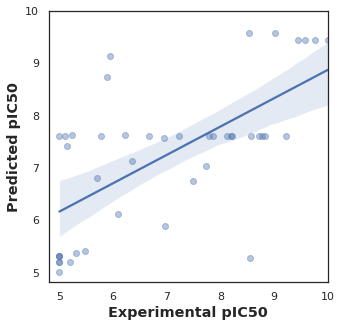

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(4.8, 10)
ax.set_ylim(4.8, 10)
ax.figure.set_size_inches(5, 5)
plt.show